<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q2
    Instructor: Kris                          TAs: Wen-Hsuan (Lead), Zen, Yan, Rawal, Paritosh, Qichen

In [3]:
# Libraries

import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Q2: Matthew-Bakers Inverse Compositional Alignment with Affine Matrix

### Q2.1: Implementation (10 PT write-up, 20 PT implementation)
Now we will implement the Matthew-Bakers tracker to alleviate the computational costs of the the Lucas-Kanade tracker, as it only calculates the Hessian and Jacobian once per each video. Write the function with the following function signature:

```
            M = InverseCompositionAffine(It, It1, rect)
```
that computes the optimal local motion represented by a $2x3$ affine transformation matrix $M$ from frame $I_t$ to frame $I_{t+1}$ that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

The inputs are structured identically to Q1.2, but you should replace the forward alignment algorithm with the inverse compositional alignment algorithm. You may also find these materials useful: [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) and [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2003_3/baker_simon_2003_3.pdf).

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code. Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do they have those differences? At what point does the algorithm break down and why does this happen?

In [99]:
def InverseCompositionAffine(It, It1, rect, thresh=.025, maxIt=100):
    '''
    Q2.1: Matthew-Bakers Inverse Compositional Alignment with Affine MAtrix
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        M: Affine mtarix (2x3)
    '''
    # ----- TODO -----
    # YOUR CODE HERE
        # Set thresholds (you probably want to play around with the values)
    W = np.identity(3)
    dp = np.ones(6)
    p = np.array([1.,0.,0.,0.,1.,0.])
    threshold = thresh
    maxIters = maxIt
    i = 0
    x1, y1, x2, y2 = rect
    
    
    height, width = It.shape
    
    # ----- TODO -----
    # YOUR CODE HERE
    ## image gradient
    #gy, gx = np.gradient(It1)
    gy, gx = It, It
    
    intep_y, intep_x = int(y2-y1), int(x2-x1)
    # intep_y, intep_x = 2*(y2-y1), 2*(x2-x1)
    
    y = np.arange(0, height, 1)
    x = np.arange(0, width, 1)
    current_linespace_x = np.linspace(x1, x2+0.1, intep_x)
    current_linespace_y = np.linspace(y1, y2+0.1, intep_y)
    current_grid_y, current_grid_x = np.meshgrid(current_linespace_y, current_linespace_x)
    
    interpolator_gx = RectBivariateSpline(y, x, gx)
    interpolator_gy = RectBivariateSpline(y, x, gy)
    interpolator_Current = RectBivariateSpline(y, x, It)
    interpolator_Next = RectBivariateSpline(y, x, It1)
    
    Template = interpolator_Current.ev(current_grid_y, current_grid_x)
    Ix = interpolator_gx.ev(current_grid_y, current_grid_x, dx=0, dy=1)
    Iy = interpolator_gy.ev(current_grid_y, current_grid_x, dx=1, dy=0)
    
    I = np.vstack((Ix.ravel(),Iy.ravel())).T #(N, 2)
    
    jac_W = [np.array([[x, 0, y, 0, 1, 0],[0, x, 0, y, 0, 1]]) \
             for y,x in zip(current_grid_y.ravel(), current_grid_x.ravel())]
#     jac_W = [np.array([[x, y, 1, 0, 0, 0],[0, 0, 0, x, y, 1]]) \
#              for y,x in zip(current_grid_y.ravel(), current_grid_y.ravel())]
    jac_W = np.array(jac_W) #(N, 2, 6)
    
    A = np.einsum("nc, ncp -> np", I, jac_W)
    
    i = 0
    while (np.sum(np.square(dp)) > 0.01) and (i <= maxIters):
        #print(W)
        i += 1
        # warp the template
        warp_grid_x =  current_grid_x * W[0,0] +  current_grid_y * W[0,1] + W[0,2]
        warp_grid_y =  current_grid_x * W[1,0] +  current_grid_y * W[1,1] + W[1,2]
        
        warp_I = interpolator_Next.ev(warp_grid_y, warp_grid_x)
        
        err = (warp_I-Template).reshape(-1)
        #err = (Template-warp_I).reshape(-1)
        
        dp,_,_,_ = np.linalg.lstsq(A,err,rcond=None)
        
        #dW = np.vstack((dp.reshape(2,3), [0, 0, 1]))
        #dW[0,0]+=1;dW[1,1]+=1;
        dW = np.array([[dp[0]+1, dp[2], dp[4]],[dp[1], dp[3]+1, dp[5]],[0,0,1]])
        W = W @ np.linalg.inv(dW)
        #W = W @ (dW)
        
    
    W = W[:2,:]
    
    return W

[440.53514003  78.8702973  561.33638502 139.48808994]


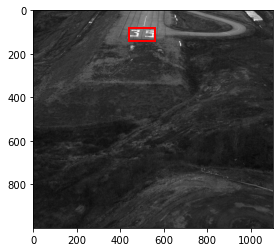

[441.37835053  80.84031195 563.05839737 141.83636315]


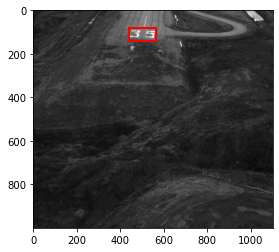

[443.42583746  80.92167383 566.28055498 141.63554996]


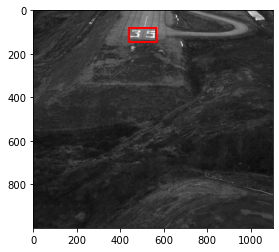

[441.70352086  78.34168746 565.72387613 139.34995196]


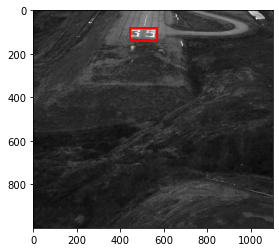

[438.65581264  80.16526738 563.56629719 141.45132385]


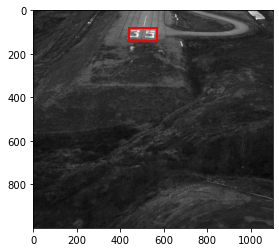

[436.82774385  78.86159371 562.89946368 140.1052122 ]


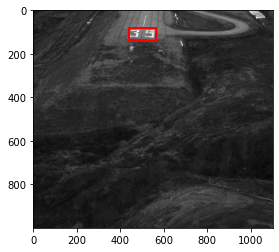

[433.43659493  78.84790195 560.61902111 140.32324619]


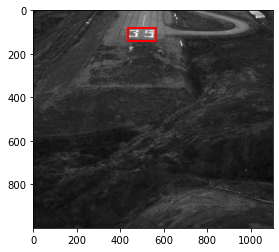

[429.62316797  77.64207025 557.82723718 139.49645273]


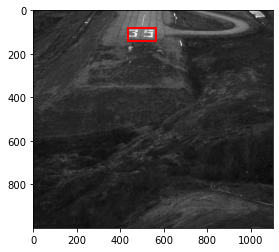

[426.68127616  78.80616354 556.00659894 140.86438327]


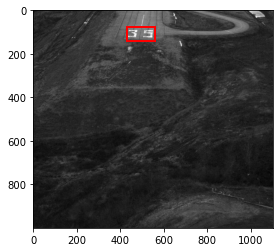

[424.30389891  79.37996675 554.97977428 141.37489083]


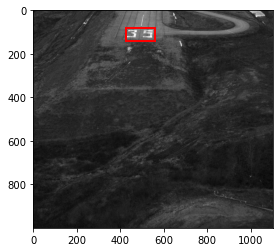

[422.02802052  78.59395031 552.0233378  140.79638075]


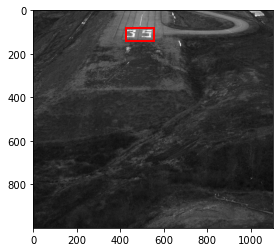

[415.91496128  80.99549268 546.92106694 143.58155949]


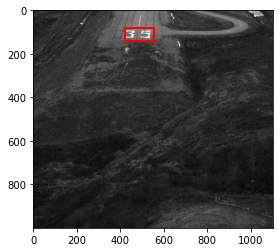

[408.90529144  83.32571021 543.65274721 146.31531302]


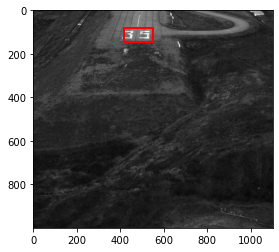

[408.47694216  86.86629547 545.80696525 149.90388848]


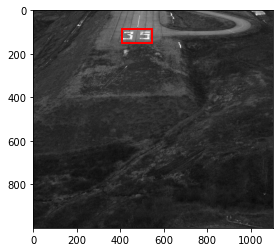

[406.52296882  86.52926379 544.86646053 150.24329292]


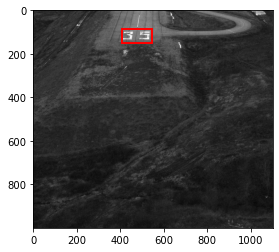

[406.2544429   89.96988104 545.55888945 154.31387776]


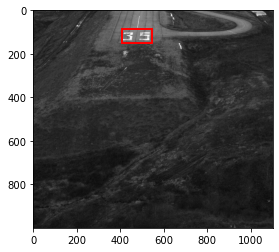

[406.84110799  90.61662634 547.39263411 155.40040752]


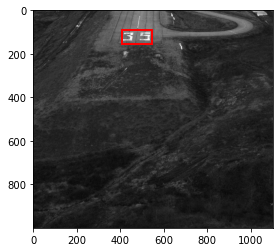

[406.58262801  90.7202074  547.98073049 156.40569502]


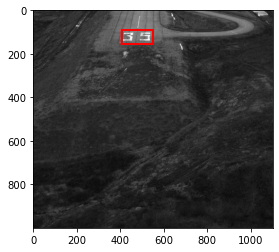

[411.80063304  93.09712577 555.19436277 160.48695786]


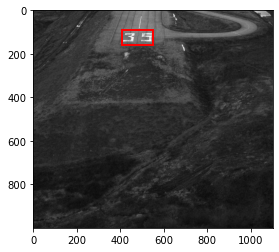

[413.38843485  95.03917504 559.63129333 163.85047689]


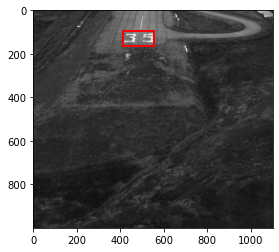

[414.21963616  97.13838626 561.82071573 166.06761408]


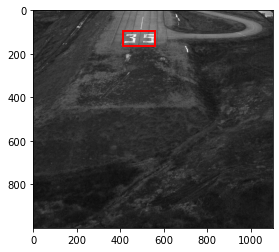

[412.36070835  97.52182252 561.44875066 166.84648697]


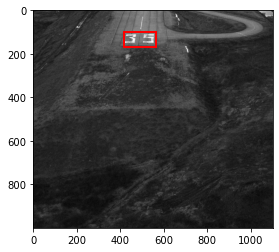

[408.96800716 100.44697554 559.07252301 170.54295629]


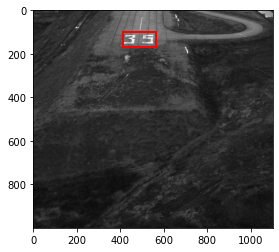

[404.44348135 106.33736296 557.57955489 176.70562564]


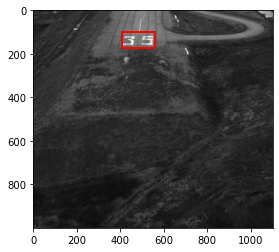

[394.14638162 108.59834519 549.66475469 180.71504706]


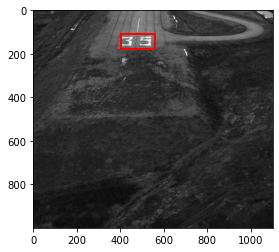

[394.78105276 108.85908822 551.73593709 181.44110919]


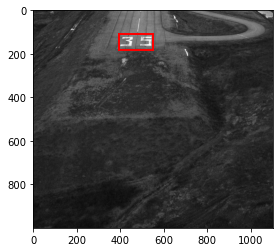

[396.14238051 105.69755618 554.39377135 179.15541444]


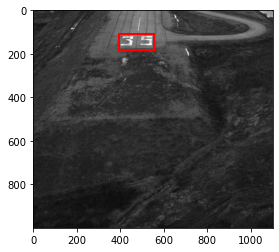

[397.91907837 104.80740725 557.24760188 179.58789842]


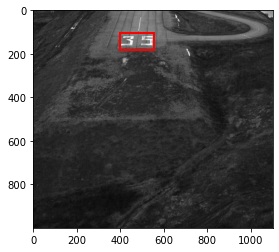

[405.11017075 104.81613634 567.01849025 180.99478344]


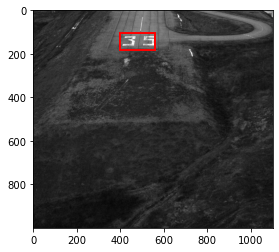

[407.42495699 105.63472424 570.93744158 182.38409982]


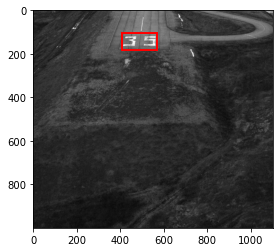

[411.24990984 111.73012205 577.8139459  189.38504772]


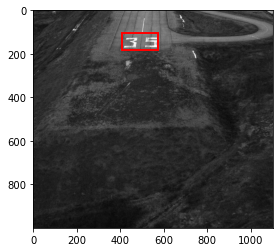

[413.51728176 112.38331186 581.91286053 190.09075   ]


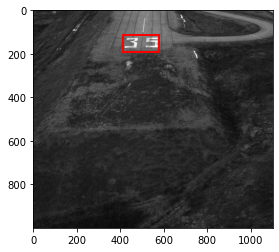

[411.22319141 113.51567625 581.10612239 192.14813664]


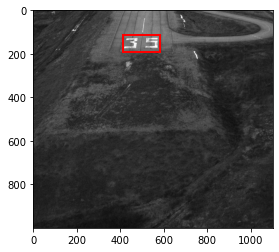

[406.61496255 114.62791009 578.02624656 193.93876973]


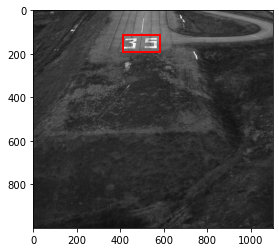

[390.43039212 111.66360041 565.31886984 192.23760099]


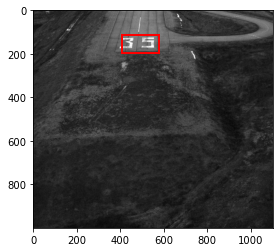

[374.19985377 107.26660072 552.34866583 189.7076665 ]


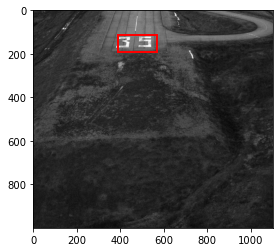

[368.67878236 106.75858171 548.5574201  189.8251245 ]


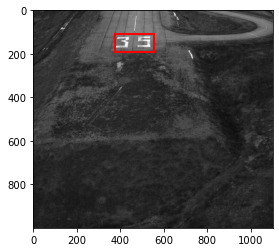

[365.58767649 105.24871361 544.16445681 189.66628484]


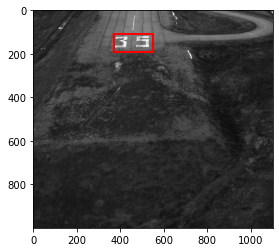

[363.93266992 108.11848242 540.48726851 192.36212404]


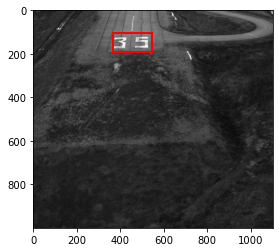

[365.37343799 109.37548213 547.32049436 195.55671727]


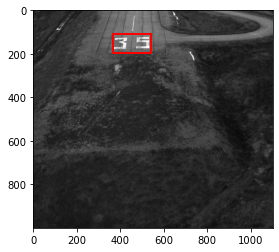

[377.44984315 107.58906619 563.80576402 197.83806047]


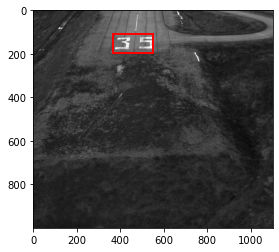

[379.15801254 107.69378583 566.77882388 200.08867964]


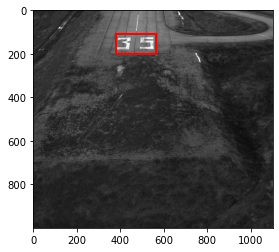

[384.19277183 105.44081858 574.94354933 201.01948116]


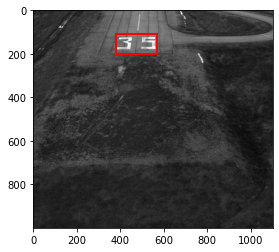

[372.37308145 105.48228752 570.86824402 205.59395211]


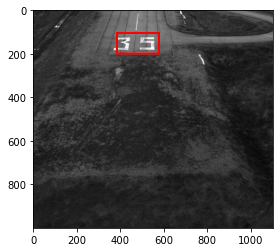

[346.78292364  99.26828551 552.33172644 202.14046298]


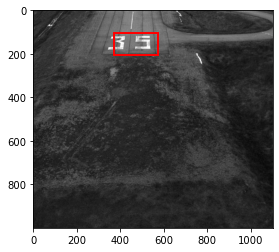

[336.98269539  96.63064131 544.82008193 200.45182476]


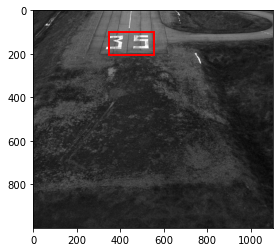

[318.79609164 101.3846573  534.34713021 207.72802029]


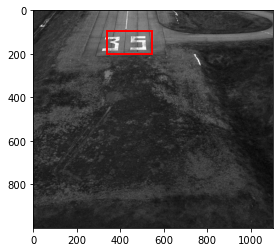

[314.60165496 102.59505865 532.27440773 210.79618223]


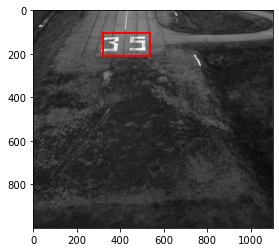

[317.24244051 108.23063961 541.66138543 221.05282549]


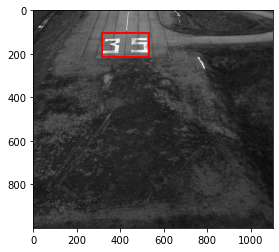

In [100]:
# Test your algorithm and visualize results!

# Load data
data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
data = np.load('./data/%s.npy' % data_name)

# obtain the initial rect with format (x1, y1, x2, y2)
if data_name == 'car1':
    initial = np.array([170, 130, 290, 250])
elif data_name == 'car2':
    initial = np.array([59, 116, 145, 151])
elif data_name == 'landing':
    initial = np.array([440, 80, 560, 140])
elif data_name == 'race':
    initial = np.array([170, 270, 300, 370])
elif data_name == 'ballet':
    initial = np.array([700, 210, 775, 300])
else:
    assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

numFrames = data.shape[2]
w = initial[2] - initial[0]
h = initial[3] - initial[1]

# loop over frames
rects = []
rects.append(initial)

for i in range(numFrames-1):

    It = data[:,:,i]
    It1 = data[:,:,i+1]
    rect = rects[i]

    # run algorithm and collect rects
    M = InverseCompositionAffine(It, It1, rect)
    corners = np.array([[rect[0], rect[1], 1], 
                        [rect[2], rect[3], 1]]).transpose()
    newRect = np.matmul(M, corners).transpose().reshape((4, ))
    rects.append(newRect)
    print(newRect)

    # Visualize
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
    plt.imshow(It1, cmap='gray')
    plt.show()
    ax.clear()

In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.


### Q2.2: Comparing Your Algorithms (write-up only, 10 PT)
Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do we have those differences?  At what point does the algorithm break down and why does this happen?